### Predicting Prices for Boston Housing

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do **feature-wise normalization**: for each feature in the input data (a column in the input data matrix), you **subtract the mean of the feature** and **divide by the standard deviation**, so that the feature is centered around 0 and has a unit standard deviation.

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### Building the network

In [3]:
from keras import layers, models

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model
    

The network ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range the out- put can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only learn to predict values between 0 and 1.

### Validation using K-fold validation

In [8]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #',i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1)*num_val_samples:]],
                                       axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                         train_targets[(i+1)*num_val_samples:]],
                                       axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0)
    
    mae_history = history.history['mean_absolute_error']
    all_mae_histories.append(mae_history)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)



processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

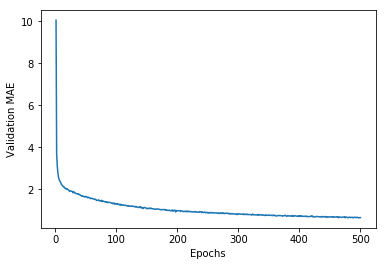

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Smoothing the curve

Excluding the first ten data points since they are on a different scale compared to the rest of the curve.
Replace each point with an exponential moving average of the previous points,
to obtain a smooth curve

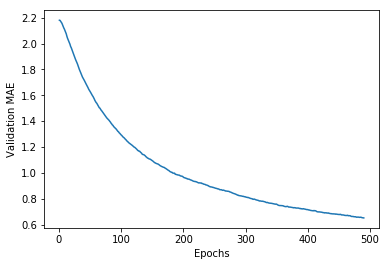

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points: 
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else: 
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])


plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

* Regression is done using different loss functions than what we used for classifi- cation. Mean squared error (MSE) is a loss function commonly used for regres- sion.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reli- ably evaluate a model.
* When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.